In [19]:
from google.colab import drive
#mount your drive.  Complete Oauth to authenticate
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


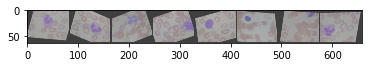

In [24]:
from torchvision.utils import make_grid
import torchvision.datasets as datasets


transformations = transforms.Compose([
        transforms.Resize((60, 80),2),    # Resizes to 1/16 the size of the original image for speed.
        transforms.ToTensor()])
full_train_set = datasets.ImageFolder("/content/gdrive/My Drive/TRAIN", transform=transformations)
train_data = torch.utils.data.DataLoader(full_train_set, batch_size=8, shuffle=True)
images, labels = next(iter(train_data))
def show_images(img):
    img = img * .473 + .25     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
#visualize
show_images(make_grid(images))

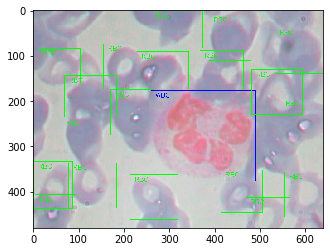

In [34]:
import cv2
import xml.etree.ElementTree as ET

#slight adaption from: https://github.com/Shenggan/BCCD_Dataset/scripts/

def parse_single(img, ann):
    image = cv2.imread(img)
    tree = ET.parse(ann)
    for elem in tree.iter():
        if 'object' in elem.tag or 'part' in elem.tag:
                for attr in list(elem):
                        if 'name' in attr.tag:
                                name = attr.text
                        if 'bndbox' in attr.tag:
                                for dim in list(attr):
                                        if 'xmin' in dim.tag:
                                                xmin = int(round(float(dim.text)))
                                        if 'ymin' in dim.tag:
                                                ymin = int(round(float(dim.text)))
                                        if 'xmax' in dim.tag:
                                                xmax = int(round(float(dim.text)))
                                        if 'ymax' in dim.tag:
                                                ymax = int(round(float(dim.text)))
                                if name[0] == "R":
                                        cv2.rectangle(image, (xmin, ymin),
                                                                (xmax, ymax), (0, 255, 0), 1)
                                        cv2.putText(image, name, (xmin + 10, ymin + 15),
                                                        cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 255, 0), 1)
                                if name[0] == "W":
                                        cv2.rectangle(image, (xmin, ymin),
                                                                (xmax, ymax), (0, 0, 255), 1)
                                        cv2.putText(image, name, (xmin + 10, ymin + 15),
                                                        cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 0, 255), 1)
                                if name[0] == "P":
                                        cv2.rectangle(image, (xmin, ymin),
                                                                (xmax, ymax), (255, 0, 0), 1)
                                        cv2.putText(image, name, (xmin + 10, ymin + 15),
                                                        cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (255, 0, 0), 1)
    return image


img_path = "/content/gdrive/My Drive/blood_sample_image.jpg"
ann_path = "/content/gdrive/My Drive/blood_sample_overlay.xml"

image = parse_single(img_path, ann_path)


plt.imshow(image)

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
[2497, 2483, 2478, 2499]


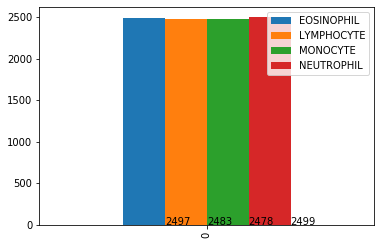

In [59]:
import pandas as pd

cls_names = [d_name for d_name in os.listdir("/content/gdrive/My Drive/TRAIN/")]
#check distribution
cls_counts = []
for directory in os.listdir("/content/gdrive/My Drive/TRAIN/"):

  os.chdir("/content/gdrive/My Drive/TRAIN/" + directory)
  cls_counts.append(len([file for file in os.listdir()]))


print(cls_names)
print(cls_counts)
df = pd.DataFrame([cls_counts], columns=cls_names)

plot = df.plot.bar()
for p in plot.patches:
   plot.annotate(str(p.get_height()),(p.get_x() + p.get_width(), p.get_y()))

Accuracy
Training Loss
Validation Loss


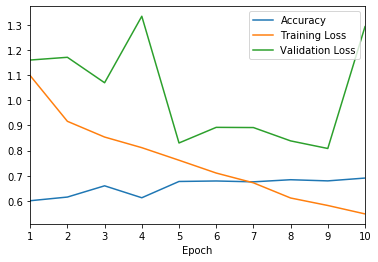

In [124]:
#we did not store our runs in a formatted way, a bit of cleansing is required
import re

#format for input run string
run_str = """
Epoch: 1 Accuracy: 0.600415 Training Loss: 1.097977 Validation Loss: 1.160111#
Epoch: 2 Accuracy: 0.615024 Training Loss: 0.916336 Validation Loss: 1.170981# 
Epoch: 3 Accuracy: 0.659744 Training Loss: 0.853748 Validation Loss: 1.069735# 
Epoch: 4 Accuracy: 0.612244 Training Loss: 0.811477 Validation Loss: 1.334290# 
Epoch: 5 Accuracy: 0.677024 Training Loss: 0.761510 Validation Loss: 0.830155# 
Epoch: 6 Accuracy: 0.678963 Training Loss: 0.710578 Validation Loss: 0.892294# 
Epoch: 7 Accuracy: 0.675573 Training Loss: 0.671650 Validation Loss: 0.891510# 
Epoch: 8 Accuracy: 0.683963 Training Loss: 0.611281 Validation Loss: 0.838476# 
Epoch: 9 Accuracy: 0.679354 Training Loss: 0.581496 Validation Loss: 0.808214# 
Epoch: 10 Accuracy: 0.690573 Training Loss: 0.547951 Validation Loss: 1.292905# 
"""
def run_str_to_df(run_str): 
  data = []
  #split by lines and skip first empty line
  for line in run_str.splitlines()[1:]:
    #find the accuracies using regex
    record = [re.search("Epoch: (.*?) ", line).group(0), re.search("Accuracy: (.*?) ", line).group(0), re.search("Training Loss: (.*?) ", line).group(0), re.search("Validation Loss: (.*?)#", line).group(0).replace("#", "")]
    #get only numerical value from each record
    for n, r in enumerate(record):
      record[n] = float(r.split(": ")[1])
    data.append(record)
  return pd.DataFrame(data, columns=["Epoch", "Accuracy", "Training Loss", "Validation Loss"])



def plot_results(df):
  ax = plt.gca()
  for col in df.columns[1:]:
    df.plot.line(x="Epoch", y=col, ax=ax)
  plt.show()

df = run_str_to_df(run_str)
df.head()
plot_results(df)